<a href="https://colab.research.google.com/github/itzem-vg/Practicos-SIS420-COM200/blob/main/LAB5/PUNTO2_OFICIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **APRENDIZAJE NO SUPERVISADO**

In [ ]:
#Librerias
#Libreria para leer y escribir datos en varios formatos
import scipy.io
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
# Manipulación y análisis de datos
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Importación del Dataset


#### Importamos las imagenes y las convertimos en un .mat

In [ ]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
from scipy.io import loadmat

# modulo para guardar archivos en formato MATLAB
from scipy.io import savemat

# División de los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

# Librería para procesamiento de imágenes
import cv2

# Importar las bibliotecas necesarias
import os  # Para trabajar con rutas de archivos y carpetas

# Ruta a la carpeta principal del dataset (donde están las imágenes de cada clase)
dataset_folder = r'archive (14)\seg_train\seg_train'

# Inicializar listas vacías para almacenar las imágenes y sus etiquetas correspondientes
images = []
labels = []

# Definir las clases y asignarles un índice.
# Cada clase corresponde a una carpeta dentro del dataset.
clases = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
# Crear un diccionario donde cada clase se le asigna un número único (índice)
clase_indices = {clase: idx for idx, clase in enumerate(clases)}

# Iterar sobre cada clase (buildings, forest, etc.)
for clase in clases:
    # Crear la ruta a la carpeta que contiene las imágenes de la clase actual
    clase_folder = os.path.join(dataset_folder, clase)
    # Obtener el índice (etiqueta) correspondiente a la clase
    label = clase_indices[clase]

    # Iterar sobre cada archivo de imagen en la carpeta de la clase actual
    for image_name in os.listdir(clase_folder):
        # Crear la ruta completa de la imagen
        image_path = os.path.join(clase_folder, image_name)

        # Leer la imagen usando OpenCV en escala de grises (IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Si la imagen se leyó correctamente (image no es None)
        if image is not None:
            # Redimensionar la imagen a 64x64 píxeles para tener un tamaño uniforme
            image = cv2.resize(image, (150, 150))
            # Agregar la imagen redimensionada a la lista de imágenes
            images.append(image)
            # Agregar la etiqueta de la clase correspondiente a la lista de etiquetas
            labels.append(label)

# Convertir las listas de imágenes y etiquetas a arrays de numpy
# Esto es más eficiente y fácil de manejar en machine learning
images = np.array(images)
labels = np.array(labels)

# Definir la ruta donde se guardará el archivo .mat
save_path = 'ya.mat'

# Guardar las imágenes y etiquetas en un archivo .mat
# Esto permite trabajar con el dataset tanto en MATLAB como en Python
savemat(save_path, {'images': images, 'labels': labels})

Esto nos devuelve un .MAT que posteriormente en el siguiente contenedor de codigo importamos (Uno de TRAIN y otro de TEST)

In [ ]:
# Cargar el dataset
MAT_train_dict=scipy.io.loadmat('/content/drive/MyDrive/Lab 5 grupo Dinamita/Datasets- Lab 5/trian-RGB.mat')
MAT_test_dict=scipy.io.loadmat('/content/drive/MyDrive/Lab 5 grupo Dinamita/Datasets- Lab 5/test-RGB.mat')

**.MAT de TRAIN**

Guardamos en X_train -> imagenes

Guardamos en y_train -> labels

In [ ]:
# Supongamos que las variables en el .mat son 'X' (imágenes) y 'y' (etiquetas)
X_train = MAT_train_dict['images']  # Datos de las imágenes (array de NumPy)
y_train = MAT_train_dict['labels']  # Etiquetas (array de NumPy)

X_train.shape

(14034, 150, 150, 3)

**.MAT de TEST**

Guardamos en X_test -> imagenes

Guardamos en y_test -> labels

In [ ]:
# Supongamos que las variables en el .mat son 'X' (imágenes) y 'y' (etiquetas)
X_test = MAT_test_dict['images']  # Datos de las imágenes (array de NumPy)
y_test = MAT_test_dict['labels']  # Etiquetas (array de NumPy)

X_test.shape

(3000, 150, 150, 3)

#### Tratado de imagenes con Pytorch

In [ ]:
import torch
print(torch.cuda.is_available())  # Esto debe devolver True si tienes GPU activa

True


Convertimos las imagenes de datos en pixeles, a datos tipo caracteristicas en cada columna

Para TRAIN

Esto nos va a devolver una variable features con todas las caracteristicas de todos los ejemplos de train

**(Como un nuevo dataset de caracteristicas)**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from scipy.io import loadmat
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from scipy.io import loadmat
import numpy as np


# Paso 0: Configurar el dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Definir el dispositivo
print(f'Usando el dispositivo: {device}')

# Paso 1: Cargar el modelo preentrenado ResNet18 y modificarlo para extracción de características
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Usar los pesos actualizados
# Quitamos la última capa (fully connected) para usar las características
model = nn.Sequential(*list(model.children())[:-1])
model = model.to(device)  # Mover el modelo a la GPU
model.eval()  # No entrenaremos el modelo, solo lo usamos para extracción

# Paso 2: Definir las transformaciones para redimensionar y normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet espera 224x224
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar como en ImageNet
])

# Paso 3: Cargar tu dataset en formato .mat y definir el Dataset personalizado
class CustomDataset(Dataset):
    def __init__(self, mat_data, transform=None):
        self.images = mat_data['images']  # Asegúrate de que esta clave sea correcta
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Extraer la imagen del dataset
        image = self.images[idx]
        # Asegúrate de que la imagen esté en formato correcto (por ejemplo, uint8) para convertirla a imagen PIL
        image = Image.fromarray(image.astype('uint8'))  # Convertir a formato PIL
        if self.transform:
            image = self.transform(image)
        return image

# Paso 4: Cargar el archivo .mat
mat_data = loadmat('/content/drive/MyDrive/Lab 5 grupo Dinamita/Datasets- Lab 5/trian-RGB.mat')

# Crear el dataset personalizado con las transformaciones
dataset = CustomDataset(mat_data, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Paso 5: Extraer características para todas las imágenes
features = []
with torch.no_grad():  # No necesitamos gradientes para esta operación
    for images in dataloader:
        images = images.to(device)  # Mover las imágenes a la GPU
        output = model(images)  # Pasar las imágenes por ResNet18
        output = output.view(output.size(0), -1)  # Convertir la salida en un vector
        features.append(output.cpu())  # Mover el resultado de vuelta a la CPU para almacenarlo

# Concatenar todas las características
features = torch.cat(features).numpy()  # Convertir a numpy si lo necesitas para clustering


Usando el dispositivo: cuda


Para TEST

Esto nos va a devolver una variable features con todas las caracteristicas de todos los ejemplos de test

**(Como un nuevo dataset de caracteristicas)**

In [ ]:
# Paso 0: Configurar el dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Definir el dispositivo
print(f'Usando el dispositivo: {device}')

# Paso 1: Cargar el modelo preentrenado ResNet18 y modificarlo para extracción de características
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Usar los pesos actualizados
# Quitamos la última capa (fully connected) para usar las características
model = nn.Sequential(*list(model.children())[:-1])
model = model.to(device)  # Mover el modelo a la GPU
model.eval()  # No entrenaremos el modelo, solo lo usamos para extracción

# Paso 2: Definir las transformaciones para redimensionar y normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet espera 224x224
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar como en ImageNet
])

# Paso 3: Cargar tu dataset en formato .mat y definir el Dataset personalizado
class CustomDataset(Dataset):
    def __init__(self, mat_data, transform=None):
        self.images = mat_data['images']  # Asegúrate de que esta clave sea correcta
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Extraer la imagen del dataset
        image = self.images[idx]
        # Asegúrate de que la imagen esté en formato correcto (por ejemplo, uint8) para convertirla a imagen PIL
        image = Image.fromarray(image.astype('uint8'))  # Convertir a formato PIL
        if self.transform:
            image = self.transform(image)
        return image

# Paso 4: Cargar el archivo .mat
mat_data = loadmat('/content/drive/MyDrive/Lab 5 grupo Dinamita/Datasets- Lab 5/test-RGB.mat')

# Crear el dataset personalizado con las transformaciones
dataset = CustomDataset(mat_data, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Paso 5: Extraer características para todas las imágenes
features_test = []
with torch.no_grad():  # No necesitamos gradientes para esta operación
    for images in dataloader:
        images = images.to(device)  # Mover las imágenes a la GPU
        output = model(images)  # Pasar las imágenes por ResNet18
        output = output.view(output.size(0), -1)  # Convertir la salida en un vector
        features_test.append(output.cpu())  # Mover el resultado de vuelta a la CPU para almacenarlo

# Concatenar todas las características
features_test = torch.cat(features_test).numpy()  # Convertir a numpy si lo necesitas para clustering

Usando el dispositivo: cuda


Imprimimos las dimensiones de nuestras caracteristicas

*  **features** será ahora nuestra **X_train**

*  **features_test** será ahora nuestra **X_test**

In [ ]:
print(features.shape)
print("----------------------------------------------")
print(features_test.shape)

(14034, 512)
----------------------------------------------
(3000, 512)


Ya tenemos nuestro dataset tratado y listo para buscar predecir las clases con K-MEANS

### Aplicacion de **MiniBatch K-Means**

Declaramos el modelo y definimos el modelo y lo utilizamos para encontrar
las **imagenes distintivas**

In [ ]:
from sklearn.cluster import MiniBatchKMeans

k = 50
batch_size = 100  # Tamaño del LOTE de datos que iremos metiendo a la memoria
minibatch_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=42)

# Aplica MiniBatchKMeans
X_imagenes_dist = minibatch_kmeans.fit_transform(features)
X_imagenes_dist

array([[18.119951 , 15.401325 , 15.127236 , ..., 16.824423 , 13.5815935,
        13.775948 ],
       [20.241188 , 18.99322  , 15.252747 , ..., 18.24486  , 11.872056 ,
        19.036104 ],
       [20.225658 , 18.33501  , 15.851682 , ..., 18.247723 , 14.195952 ,
        20.092577 ],
       ...,
       [18.806232 , 17.687817 ,  9.345499 , ..., 12.474028 , 12.248071 ,
        18.22012  ],
       [21.500824 , 19.959314 , 12.967247 , ..., 14.68204  , 13.585358 ,
        20.167807 ],
       [19.781164 , 19.784029 , 14.813259 , ..., 16.692644 , 16.096804 ,
        19.798939 ]], dtype=float32)

Aqui obtenemos los indices a los que pertenecian nuestras imagenes distintivas

In [ ]:
idxs = np.argmin(X_imagenes_dist, axis=0)
X_representative_images = features[idxs]

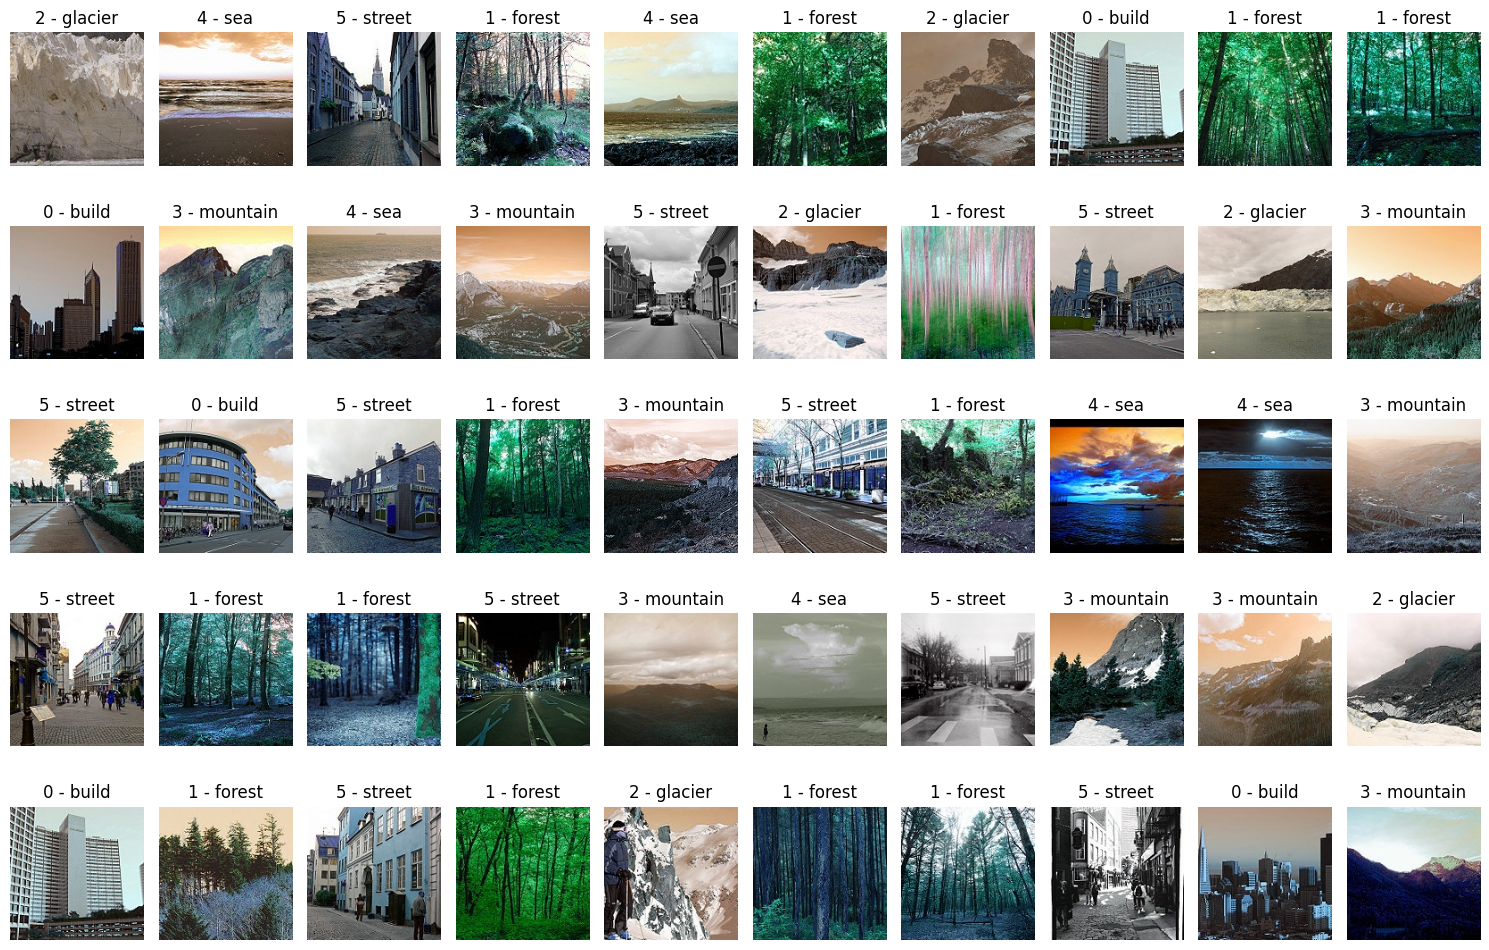

In [ ]:
X_representative_images_array = X_train[idxs]

y_train_graf = y_train.T

import matplotlib.pyplot as plt

# Diccionario para las etiquetas
class_names = {
    0: "build",
    1: "forest",
    2: "glacier",
    3: "mountain",
    4: "sea",
    5: "street"
}

# Obtener las clases correspondientes a las imágenes representativas
labels = y_train_graf[idxs]  # Esto obtiene las clases correspondientes a las imágenes representativas

plt.figure(figsize=(15, 10))  # Ajustamos el tamaño de la figura para que se vean mejor las imágenes
for index, (X_representative_image, label) in enumerate(zip(X_representative_images_array, labels)):
    plt.subplot(5, 10, index + 1)  # Crear una cuadrícula de 5 filas y 10 columnas para las imágenes
    plt.imshow(X_representative_image.reshape(150, 150, 3))  # Reajustar las imágenes a su forma original de 150x150x3 (RGB)
    plt.axis('off')  # Ocultar los ejes
    # Convertir label a escalar y mostrar la clase debajo de la imagen con su nombre
    plt.title(f"{label.item()} - {class_names[label.item()]}")  # Mostrar la clase y su nombre

plt.tight_layout()  # Ajustar el espaciado entre subgráficas
plt.show()

Aqui asignamos una clase a los datos distintivos, como ya teniamos ys solo asignamos esas

In [ ]:
y_train_transpose = y_train.T

y_representative_images = y_train_transpose[idxs]

In [ ]:
from sklearn.linear_model import LogisticRegression

y_test_aplanado = y_test.ravel()


log_reg2 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=20000, random_state=42)
%time log_reg2.fit(X_representative_images, y_representative_images)
log_reg2.score(features_test, y_test_aplanado)

CPU times: user 58.5 ms, sys: 42.9 ms, total: 101 ms
Wall time: 53.4 ms


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.7803333333333333

#### Etiquetado
Aqui etiquetamos los demas datos respecto a los que kmeans obtiene en sus distintas clases

In [ ]:
from sklearn.cluster import KMeans
y_train_propagated = np.empty(len(X_train))
for i in range(k):
  y_train_propagated[minibatch_kmeans.labels_==i] = y_representative_images[i]

#### Prueba
Aqui hacemos regrecion Logistica para probar la efectividad del modelo

In [ ]:
log_reg3 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg3.fit(features, y_train_propagated)
log_reg3.score(features_test, y_test_aplanado)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: user 12.5 s, sys: 2.25 s, total: 14.7 s
Wall time: 9.53 s


0.804

Obtenemos un **80%** de precision del etiquetado de nuestros datos y para ver donde puede haberse equivocado nuestro modelo mostramos a continuación el Mapa de calor

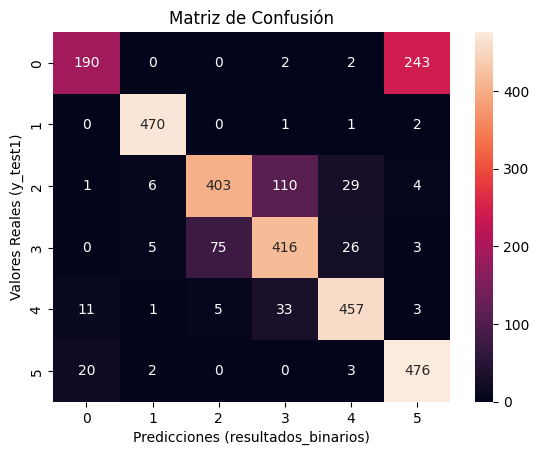

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Paso 1: Predecir las etiquetas para el conjunto de prueba
y_pred = log_reg3.predict(features_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_aplanado, y_pred)

# Visualizar la matriz
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicciones (resultados_binarios)')
plt.ylabel('Valores Reales (y_test1)')
plt.title('Matriz de Confusión')
plt.show()

## **APRENDIZAJE ACTIVO**

El aprendizaje activo (o Active Learning) consiste en entrenar modelos de ML de manera iterativa, incluyendo en cada iteración nuevas muestras al dataset focalizando en ejemplos en loa que el modelo tenga más problemas.

In [ ]:
#Utiliza el clasificador log_reg3 para predecir las probabilidades de pertenencia
# a cada clase para las primeras 1000 muestras del set de training
probas = log_reg3.predict_proba(features)

# Encuentra el índice de la clase con la probabilidad más alta para cada muestra en el conjunto de entrenamiento.
labels_ixs = np.argmax(probas, axis=1)
# Crea un arreglo labels que contiene las probabilidades correspondientes a la clase más probable para cada muestra.
labels = np.array([proba[ix] for proba, ix in zip(probas, labels_ixs)])
 #  Calcula los índices que ordenarían las probabilidades en orden ascendente.
sorted_ixs = np.argsort(labels)
 # Selecciona las probabilidades de las 10 muestras con menor confianza (mayor incertidumbre) según el modelo.
labels[sorted_ixs[:10]]

array([0.28421807, 0.31888966, 0.34104105, 0.36122498, 0.3892272 ,
       0.39875461, 0.40702929, 0.40824079, 0.40913635, 0.41003615])

In [ ]:
# Extracción de las Etiquetas de las Muestras con Mayor Incertidumbre
y_lowest = y_train.ravel()[sorted_ixs[:k]]
y_lowest

array([2, 3, 4, 2, 4, 4, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 4, 3, 3, 5,
       2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2, 2, 2, 4, 2, 2, 2, 3, 3, 3,
       2, 2, 4, 2, 2, 3], dtype=int32)

In [ ]:
# Actualización de las Etiquetas de las Muestras con Mayor Incertidumbre
y_train2 = y_train_propagated.copy()
# y_train2: Es un arreglo de etiquetas actualizado, donde las etiquetas de las k muestras
# con mayor incertidumbre en y_train_propagated han sido reemplazadas por las etiquetas correspondientes de y_lowest.

y_train2[sorted_ixs[:k]] = y_lowest

Aquí entrenamos el modelo, con las ys etiquetadas que se tenian previamente

In [ ]:
y_train_vertical = y_train.T
log_reg5 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg5.fit(features, y_train_vertical)
log_reg5.score(features_test, y_test_aplanado)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: user 12.9 s, sys: 1.38 s, total: 14.3 s
Wall time: 7.42 s


0.8983333333333333

El siguiente código crea un nuevo clasificador de regresión logística (log_reg5) y lo entrena utilizando las etiquetas actualizadas (y_train2) en un subconjunto de muestras del conjunto de entrenamiento. Luego evalúa el desempeño de este clasificador en el conjunto de prueba (X_test, y_test)

In [ ]:
# Mostramos las etiquetas de las muestras con mayor incertidumbre
log_reg5 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=20000, random_state=42)
%time log_reg5.fit(features, y_train2)

# Calculamos la precisión del clasificador log_reg5 en el conjunto de prueba.
log_reg5.score(features_test, y_test_aplanado)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


CPU times: user 12.5 s, sys: 2.33 s, total: 14.8 s
Wall time: 9.94 s


0.8013333333333333

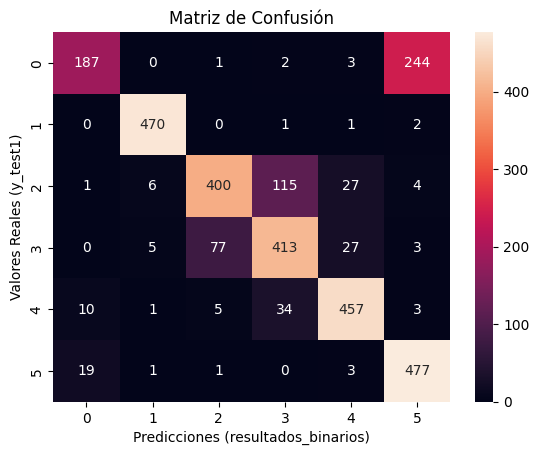

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Paso 1: Predecir las etiquetas para el conjunto de prueba
y_pred2 = log_reg5.predict(features_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_aplanado, y_pred2)

# Visualizar la matriz
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicciones (resultados_binarios)')
plt.ylabel('Valores Reales (y_test1)')
plt.title('Matriz de Confusión')
plt.show()